# Notebook for creating a dataframe ready for the two-way repeated measures MANOVA.
### Input of Notebook:
- How we swipe data set. The dataset comprises 8,831,733 touch points corresponding to 11,318 unique English words swiped by 1,338 users. There are 11,295 unique words correctly swiped and 3,767 words wrongly swiped
### Output of Notebook: 
- repeated measures data frame without outliers removed (outliers still removed for screen_size (IV))
- repeated measures data frame with outliers removed


In [1]:
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get list of all participants
directory = 'Data/swipelogs'
logfiles = Path(directory).glob('*.log')
participants = []
for file in logfiles:
    participants.append(Path(file).stem)

In [3]:
# Get simplified df of participants
def participant_basics(participant):
    # Read json data
    with open(f'Data/swipelogs/{participant}.json') as user_file:
        file_contents = user_file.read()
    data = json.loads(file_contents)

    # Calculate screen size
    size = data['screenWidth'] * data['screenHeight']
    
    return pd.DataFrame({'screen_size': size, 'swipe_finger': data['swipeFinger']}, index=[participant])   

In [4]:
# Get participant df
def participant_data(participant):
    # Read participant log file
    list = []
    file = open(f'Data/swipelogs/{participant}.log')
    line = file.readline()
    while line:
        try:
            list.append(line)
        except ValueError:
            print('Error in line :' + line )
        line = file.readline()
    df = pd.DataFrame([sub.split(" ") for sub in list])

    # Set new header
    df = df.rename(columns=df.iloc[0])
    df = df.drop(df.index[0])
    df = df.rename(columns={'is_err\n': 'errors', 'timestamp': 'duration'})

    # Select usable columns
    df = df[['sentence', 'event', 'duration', 'word', 'errors']]

    # Add participant uid
    df['uid'] = participant
    return df

In [5]:
def duration_data(participant):
    # Get participant df
    df = participant_data(participant)

    # Calculate duration
    df = df.apply(lambda row: row[df['errors'].isin(['0\n'])])
    df['duration'] = df['duration'].astype('int64')
    df = df.groupby(['sentence', 'word']).agg({ 'duration': lambda x: x.max() - x.min()})
    df = df.reset_index()
    df['time_per_char'] = df['duration'] / df['word'].str.len()

    return pd.DataFrame({'avg_char_duration': df['time_per_char']})

In [6]:
def error_data(participant):
    # Get participant df
    df = participant_data(participant)
    df_new = df.apply(lambda row: row[df['errors'].isin(['0\n'])])
    
    # Render typed words that are correctly typed in the end -> extract word and sentence
    df_and = df_new[(df_new['errors'] == '0\n') & (df['event'] == 'touchend')]
    word_df = df_and["word"]
    sentence_df = df_and["sentence"]
    
    # Iterate over word sentence pairs and render all swipe characters for these words
    error_list = []
    for i in range(len(word_df)):
        word = word_df.iloc[i]
        sentence = sentence_df.iloc[i]
        df_test = df[(df['sentence'] == sentence) & (df['word'] == word)]
        
        # Calculate wrong swiped characters and devide by total swiped characters
        wrong_swipes = len(df_test[df_test["errors"] == "1\n"])
        right_swipes = len(df_test[df_test["errors"] == "0\n"])
        error_list.append(wrong_swipes/(right_swipes+wrong_swipes))
    
    # Create dataframe of resuting error rates per word
    df_error = pd.DataFrame()
    df_error["error_rate"] = error_list
    return pd.DataFrame({'error_rate': df_error['error_rate']})

In [7]:
# Create a dataframe with participants IDs who have at least 20 correctly swiped words
# TODO: check how many participants this excludes...
participants_df = pd.DataFrame()
for participant in participants:
    df = participant_data(participant)
    df_new = df.apply(lambda row: row[df['errors'].isin(['0\n'])])
    if len(df_new.loc[df_new['event'] == "touchend"]) > 20:    
        new_values= pd.Series([participant], index=["participant"])
        participants_df= participants_df.append(new_values, ignore_index=True)
        

In [8]:
#participants_df

In [9]:
# Create empty dataframe for repeated measures
df_test = pd.DataFrame()
df_test["part"] = ""
df_test["screen_size"] = ""
df_test["swipe_finger"] = ""
df_test["ew1"] = ""
df_test["ew2"] = ""
df_test["ew3"] = ""
df_test["ew4"] = ""
df_test["ew5"] = ""
df_test["ew6"] = ""
df_test["ew7"] = ""
df_test["ew8"] = ""
df_test["ew9"] = ""
df_test["ew10"] = ""
df_test["ew11"] = ""
df_test["ew12"] = ""
df_test["ew13"] = ""
df_test["ew14"] = ""
df_test["ew15"] = ""
df_test["ew16"] = ""
df_test["ew17"] = ""
df_test["ew18"] = ""
df_test["ew19"] = ""
df_test["ew20"] = ""

df_test["t1"] = ""
df_test["t2"] = ""
df_test["t3"] = ""
df_test["t4"] = ""
df_test["t5"] = ""
df_test["t6"] = ""
df_test["t7"] = ""
df_test["t8"] = ""
df_test["t9"] = ""
df_test["t10"] = ""
df_test["t11"] = ""
df_test["t12"] = ""
df_test["t13"] = ""
df_test["t14"] = ""
df_test["t15"] = ""
df_test["t16"] = ""
df_test["t17"] = ""
df_test["t18"] = ""
df_test["t19"] = ""
df_test["t20"] = ""

In [10]:
# Merge participant ID, screen_size, swipe_finger, and calculated time and error_rate into the data frame
# One row for every participant (this function takes a while)

for index, row in participants_df.iterrows():
    info = participant_basics(row['participant'])
    error = error_data(row['participant'])[:20]
    time = duration_data(row['participant'])[:20]

    # Merge two columns (error and time) into one row
    list = [row['participant'], info.iloc[0]['screen_size'], info.iloc[0]['swipe_finger'], error.iloc[0]['error_rate'], error.iloc[1]['error_rate'], error.iloc[2]['error_rate'], error.iloc[3]['error_rate'], error.iloc[4]['error_rate'], error.iloc[5]['error_rate'], error.iloc[6]['error_rate'], error.iloc[7]['error_rate'], error.iloc[8]['error_rate'], error.iloc[9]['error_rate'], error.iloc[10]['error_rate'], error.iloc[11]['error_rate'], error.iloc[12]['error_rate'], error.iloc[13]['error_rate'], error.iloc[14]['error_rate'], error.iloc[15]['error_rate'], error.iloc[16]['error_rate'], error.iloc[17]['error_rate'], error.iloc[18]['error_rate'], error.iloc[19]['error_rate'], time.iloc[0]['avg_char_duration'], time.iloc[1]['avg_char_duration'], time.iloc[2]['avg_char_duration'], time.iloc[3]['avg_char_duration'], time.iloc[4]['avg_char_duration'], time.iloc[5]['avg_char_duration'], time.iloc[6]['avg_char_duration'], time.iloc[7]['avg_char_duration'], time.iloc[8]['avg_char_duration'], time.iloc[9]['avg_char_duration'], time.iloc[10]['avg_char_duration'], time.iloc[11]['avg_char_duration'], time.iloc[12]['avg_char_duration'], time.iloc[13]['avg_char_duration'], time.iloc[14]['avg_char_duration'], time.iloc[15]['avg_char_duration'], time.iloc[16]['avg_char_duration'], time.iloc[17]['avg_char_duration'], time.iloc[18]['avg_char_duration'], time.iloc[19]['avg_char_duration']]
    df_test.loc[len(df_test)] = list

In [11]:
# Show resulting repeated measures data frame
df_test

,part,screen_size,swipe_finger,ew1,ew2,ew3,ew4,ew5,ew6,ew7,...,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
0,0069j4rbe1si9pjqgfhks8sprm,339076,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,171.750000,152.833333,166.000000,141.333333,172.000000,133.250000,179.500000,106.200000,147.000000,200.333333
1,00h10g2j0m7vujuscdvispdkub,280800,Index,0.0,0.626667,0.000000,0.0,0.10084,0.0,0.000000,...,473.500000,506.250000,394.500000,166.000000,481.000000,624.166667,272.333333,386.750000,809.571429,470.500000
2,01rg5cvptn05eag69m0gckjer9,370944,Thumb,0.0,0.378261,0.000000,0.0,0.00000,0.0,0.507937,...,653.300000,172.333333,242.166667,137.666667,183.750000,451.333333,543.222222,490.666667,489.800000,234.000000
3,038qovd34aj82cqc9ip8fqu6sc,230400,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,775.375000,324.571429,305.800000,200.000000,295.666667,177.000000,351.000000,296.666667,606.750000,323.000000
4,03ft0n5ol992m393fb9lpc0uqt,370944,Index,0.0,0.000000,0.493333,0.0,0.00000,0.0,0.000000,...,113.833333,117.714286,78.333333,134.500000,110.500000,119.500000,194.833333,121.375000,133.000000,97.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,vs9nmoj0kboa0uhoubblculnc7,370944,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,101.000000,107.333333,170.285714,310.916667,155.750000,232.222222,142.500000,133.333333,100.000000,151.250000
1081,vs9o5ggaa18pakfr7j5p7p9rj9,230400,Index,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,625.000000,415.375000,351.166667,244.500000,249.750000,211.500000,280.000000,183.000000,212.800000,89.000000
1082,vtc9pr98mr2gs793s50jg9g15m,230400,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,296.571429,243.000000,527.166667,251.333333,593.500000,385.888889,145.666667,341.428571,436.800000,358.375000
1083,vuidvssv54irp6vppd0vtlu2gq,204800,Index,0.0,0.065625,0.000000,0.0,0.00000,0.0,0.000000,...,587.666667,244.666667,510.600000,569.777778,499.000000,579.200000,364.000000,264.333333,439.285714,308.333333


## Remove outliers on screen size + make variable categorical

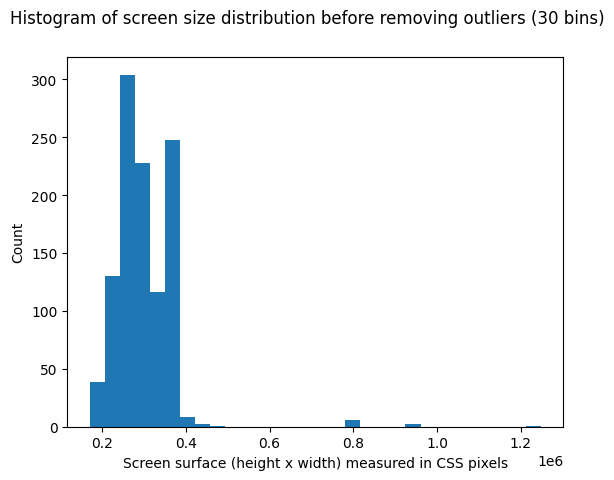

In [12]:
# Show distrubution of phone size in order to create split 
x = df_test["screen_size"]
plt.hist(x, bins=30)
plt.suptitle("Histogram of screen size distribution before removing outliers (30 bins)")
plt.ylabel("Count")
plt.xlabel("Screen surface (height x width) measured in CSS pixels")
plt.show()

In [13]:
# Function for removing outliers for screen size using Inter Quartile Range (IQR) (we only want mobile phone users and some values are very big(not a phone))
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

# Remove outliers of screen size
df_rm_outliers_screen = remove_outlier(df_test, "screen_size")

print("participants before:", len(df_test), "participants after:", len(df_rm_outliers_screen), "total removed:", len(df_test)- len(df_rm_outliers_screen))

participants before: 1085 participants after: 1076 total removed: 9


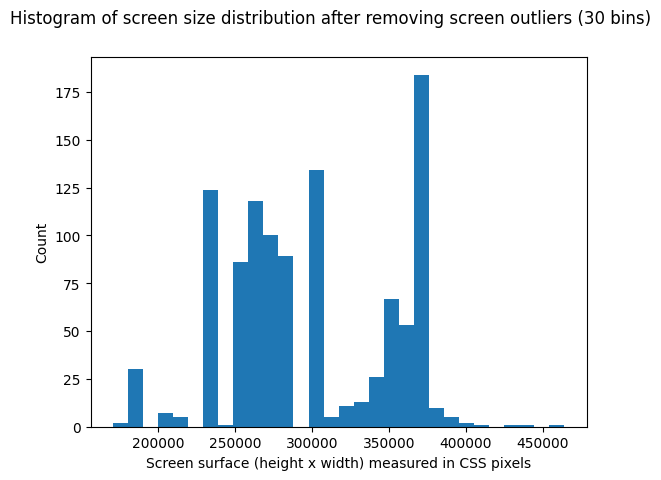

In [14]:
# Show distrubution of phone size in order to create split 
x = df_rm_outliers_screen["screen_size"]
plt.hist(x, bins=30)
plt.suptitle("Histogram of screen size distribution after removing screen outliers (30 bins)")
plt.ylabel("Count")
plt.xlabel("Screen surface (height x width) measured in CSS pixels")
plt.show()

In [15]:
# Function for replacing integer values by categorical label for screen_size
def replacing(x):
    if x <= 280000:
        return 'Small'
    elif x > 280000:
        return 'Big'

df_rm_outliers_screen['screen_size'] = df_rm_outliers_screen['screen_size'].apply(replacing)

In [16]:
# Clean dataframe
# Replace infinite updated data with nan
df_rm_outliers_screen.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
df_rm_outliers_screen.dropna(inplace=True)


In [17]:
# Save dataframe to csv file
df_rm_outliers_screen.to_csv('repeated_measures_including_outliers.csv', sep='\t', encoding='utf-8', index=False)

# Test removing outliers Time and Error rate

In [18]:
df_rm_outliers_screen

,part,screen_size,swipe_finger,ew1,ew2,ew3,ew4,ew5,ew6,ew7,...,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
0,0069j4rbe1si9pjqgfhks8sprm,Big,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,171.750000,152.833333,166.000000,141.333333,172.000000,133.250000,179.500000,106.200000,147.000000,200.333333
1,00h10g2j0m7vujuscdvispdkub,Big,Index,0.0,0.626667,0.000000,0.0,0.10084,0.0,0.000000,...,473.500000,506.250000,394.500000,166.000000,481.000000,624.166667,272.333333,386.750000,809.571429,470.500000
2,01rg5cvptn05eag69m0gckjer9,Big,Thumb,0.0,0.378261,0.000000,0.0,0.00000,0.0,0.507937,...,653.300000,172.333333,242.166667,137.666667,183.750000,451.333333,543.222222,490.666667,489.800000,234.000000
3,038qovd34aj82cqc9ip8fqu6sc,Small,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,775.375000,324.571429,305.800000,200.000000,295.666667,177.000000,351.000000,296.666667,606.750000,323.000000
4,03ft0n5ol992m393fb9lpc0uqt,Big,Index,0.0,0.000000,0.493333,0.0,0.00000,0.0,0.000000,...,113.833333,117.714286,78.333333,134.500000,110.500000,119.500000,194.833333,121.375000,133.000000,97.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,vs9nmoj0kboa0uhoubblculnc7,Big,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,101.000000,107.333333,170.285714,310.916667,155.750000,232.222222,142.500000,133.333333,100.000000,151.250000
1081,vs9o5ggaa18pakfr7j5p7p9rj9,Small,Index,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,625.000000,415.375000,351.166667,244.500000,249.750000,211.500000,280.000000,183.000000,212.800000,89.000000
1082,vtc9pr98mr2gs793s50jg9g15m,Small,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,296.571429,243.000000,527.166667,251.333333,593.500000,385.888889,145.666667,341.428571,436.800000,358.375000
1083,vuidvssv54irp6vppd0vtlu2gq,Small,Index,0.0,0.065625,0.000000,0.0,0.00000,0.0,0.000000,...,587.666667,244.666667,510.600000,569.777778,499.000000,579.200000,364.000000,264.333333,439.285714,308.333333


Mean = 1574.824782143147
Standart deviation =  30347.066233340338


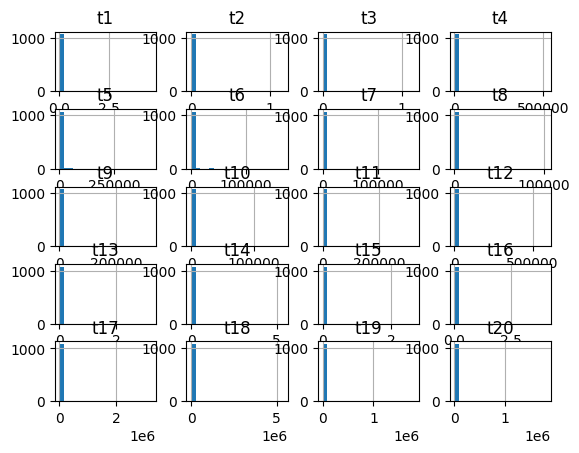

In [19]:
df = df_rm_outliers_screen

# Replace infinite updated data with nan
df.replace([np.inf, -np.inf], np.nan, inplace=True)
# Drop rows with NaN
df.dropna(inplace=True)

# Print statistics before removing outliers
print("Mean =",df.mean().mean())
print("Standart deviation = ",df.std().mean())

# Show distribution for every measure of time
hist = df_rm_outliers_screen.iloc[:,23:43].hist(bins=20)

In [20]:
# Function for removing row with outliers by using the Z-score
def remove_outliers_z(df,columns,n_std):
    for col in columns:
        print('Working on column: {}'.format(col))
        mean = df[col].mean()
        sd = df[col].std()
        df = df[(df[col] <= mean+(n_std*sd))]
    return df

# Remove outliers for every column with time measures
df_removed_z = remove_outliers_z(df_rm_outliers_screen,["t1", "t2","t3","t4","t5","t6", "t7","t8","t9","t10","t11", "t12","t13","t14","t15","t16", "t17","t18","t19","t20",],3)

Working on column: t1
Working on column: t2
Working on column: t3
Working on column: t4
Working on column: t5
Working on column: t6
Working on column: t7
Working on column: t8
Working on column: t9
Working on column: t10
Working on column: t11
Working on column: t12
Working on column: t13
Working on column: t14
Working on column: t15
Working on column: t16
Working on column: t17
Working on column: t18
Working on column: t19
Working on column: t20


mean: 141.09721591721126
standart deviation: 128.5493117004783
before: 1075 after: 982 number of outliers removed: 93


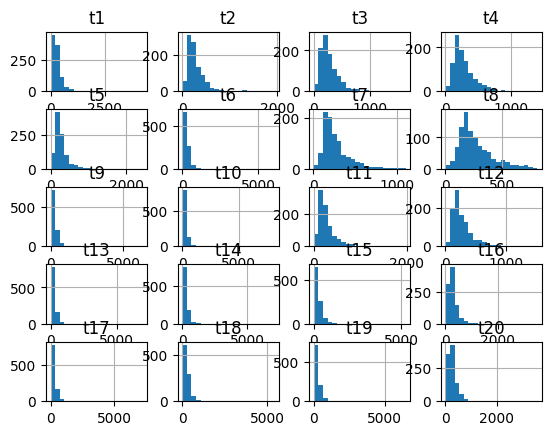

In [21]:
# Visualize distribution over the measure for time after outliers have been removed
# also print mean and standart deviation to see how this improves
print("mean:", df_removed_z.mean().mean())
print("standart deviation:", df_removed_z.std().mean())

hist = df_removed_z.iloc[:,23:43].hist(bins=20)
print("before:",len(df), "after:", len(df_removed_z), "number of outliers removed:", len(df)-len(df_removed_z))

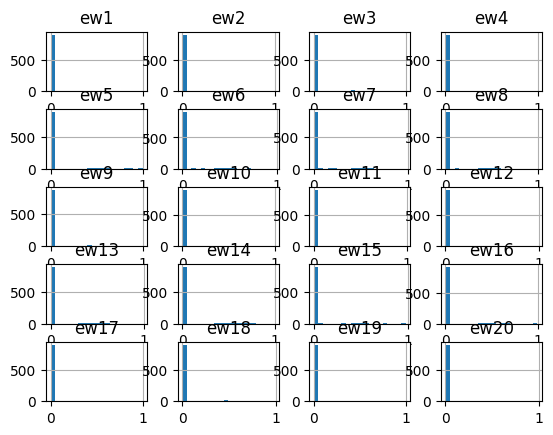

In [22]:
# Visualize distribuion over measures for the error rate
hist = df_removed_z.iloc[:,3:23].hist(bins=20)

In [23]:
#remove outliers based on error rate
df_removed_z_all = remove_outliers_z(df_removed_z,["ew1", "ew2","ew3","ew4","ew5","ew6", "ew7","ew8","ew9","ew10","ew11", "ew12","ew13","ew14","ew15","ew16", "ew17","ew18","ew19","ew20",],3)

Working on column: ew1
Working on column: ew2
Working on column: ew3
Working on column: ew4
Working on column: ew5
Working on column: ew6
Working on column: ew7
Working on column: ew8
Working on column: ew9
Working on column: ew10
Working on column: ew11
Working on column: ew12
Working on column: ew13
Working on column: ew14
Working on column: ew15
Working on column: ew16
Working on column: ew17
Working on column: ew18
Working on column: ew19
Working on column: ew20


before: 982 after: 426 number of outliers removed: 556


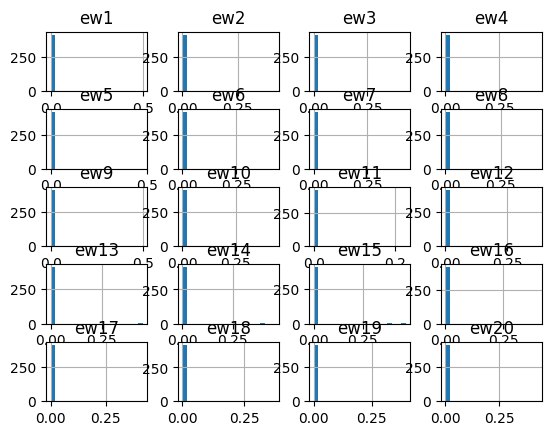

In [24]:
# Visualize distributions for measures in error rate after outliers have been removed (distribution does not change much)
# 556 outliers are removed by this, which is very high. This is due to the high skew to 0. In order to keep enough participants we will
# not remove the outliers for error rate in the dataset
print("before:",len(df_removed_z), "after:", len(df_removed_z_all), "number of outliers removed:", len(df_removed_z)-len(df_removed_z_all))
hist = df_removed_z_all.iloc[:,3:23].hist(bins=20)

In [25]:
# Show finalized dataframe
df_removed_z

,part,screen_size,swipe_finger,ew1,ew2,ew3,ew4,ew5,ew6,ew7,...,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20
0,0069j4rbe1si9pjqgfhks8sprm,Big,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,171.750000,152.833333,166.000000,141.333333,172.000000,133.250000,179.500000,106.200000,147.000000,200.333333
1,00h10g2j0m7vujuscdvispdkub,Big,Index,0.0,0.626667,0.000000,0.0,0.10084,0.0,0.000000,...,473.500000,506.250000,394.500000,166.000000,481.000000,624.166667,272.333333,386.750000,809.571429,470.500000
2,01rg5cvptn05eag69m0gckjer9,Big,Thumb,0.0,0.378261,0.000000,0.0,0.00000,0.0,0.507937,...,653.300000,172.333333,242.166667,137.666667,183.750000,451.333333,543.222222,490.666667,489.800000,234.000000
3,038qovd34aj82cqc9ip8fqu6sc,Small,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,775.375000,324.571429,305.800000,200.000000,295.666667,177.000000,351.000000,296.666667,606.750000,323.000000
4,03ft0n5ol992m393fb9lpc0uqt,Big,Index,0.0,0.000000,0.493333,0.0,0.00000,0.0,0.000000,...,113.833333,117.714286,78.333333,134.500000,110.500000,119.500000,194.833333,121.375000,133.000000,97.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,vs9nmoj0kboa0uhoubblculnc7,Big,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,101.000000,107.333333,170.285714,310.916667,155.750000,232.222222,142.500000,133.333333,100.000000,151.250000
1081,vs9o5ggaa18pakfr7j5p7p9rj9,Small,Index,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,625.000000,415.375000,351.166667,244.500000,249.750000,211.500000,280.000000,183.000000,212.800000,89.000000
1082,vtc9pr98mr2gs793s50jg9g15m,Small,Thumb,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,296.571429,243.000000,527.166667,251.333333,593.500000,385.888889,145.666667,341.428571,436.800000,358.375000
1083,vuidvssv54irp6vppd0vtlu2gq,Small,Index,0.0,0.065625,0.000000,0.0,0.00000,0.0,0.000000,...,587.666667,244.666667,510.600000,569.777778,499.000000,579.200000,364.000000,264.333333,439.285714,308.333333


In [26]:
# Save finalized data frame as csv file
df_removed_z.to_csv('repeated_measures_outliers_rm.csv', sep='\t', encoding='utf-8', index=False)